In [53]:
import torch
import torch.nn as nn
print (torch.__version__)

import time

1.2.0


In [2]:
class SDM(nn.Module):
    def __init__(self, addressDim, messageDim=None, locations=100,
                 dtype=torch.int16, readtype=torch.uint8):
        super().__init__()
        if (messageDim is None):
            messageDim = addressDim
        
        self.addressDim = addressDim
        self.messageDim = messageDim
        self.N = locations
        self.radius = addressDim//2 - 1
        self.dtype = dtype
        self.readtype = readtype
        
        self.register_buffer('locations', torch.randint(0,2, (1, locations, addressDim), dtype=torch.int8))
        self.register_buffer('counter', torch.zeros((1, locations, messageDim), dtype=dtype))
        
    def _checkInput(self, input, dim, name):
        # Input shape checking (and fixing) function
        if (len(input.shape) == 1):
            input = input.unsqueeze(0).unsqueeze(0)
        elif (len(input.shape) == 2):
            input = input.unsqueeze(1)
        elif (len(input.shape) == 3):
            pass
        else:
            raise ValueError("{} has bad shape, got {}".format(name, input.shape))
            
        if (input.shape[2] != dim):
            raise ValueError("{} has wrong dimension, got {} expected {}".format(name, input.shape[1], dim))
        
        return input
    
    def _getActive(self, address):
        with torch.no_grad():
            address = address.char()
            address = self._checkInput(address, self.addressDim, "Address")
            # Calculate Hamming distance 
            # Note the sum is int16  goes to 32,767 should avoid overflow
            # TODO try using .fmod_() (inplace modulo)
            hamming = ((self.locations + address).fmod_(2)).sum(-1, keepdim=True, dtype=torch.int16)
            # Return array
            return (hamming <= self.radius).char()
        
    
    def write(self, address, message):
        with torch.no_grad():
            message = message.char()
            message = self._checkInput(message, self.messageDim, "Message")
            message = 2 * message - 1
            
            active = self._getActive(address)
            self.counter += (active*message.expand(-1, self.N, -1)).sum(0, keepdim=True, dtype=self.dtype)
    
    def read(self, address):
        with torch.no_grad():
            active = self._getActive(address).to(self.dtype)
            result = (active*self.counter).sum(1, dtype=self.dtype)
            return (result > 0).to(self.readtype)
        

In [3]:
class SDM2(nn.Module):
    def __init__(self, addressDim, messageDim=None, locations=100,
                 dtype=torch.int16, readtype=torch.uint8):
        super().__init__()
        if (messageDim is None):
            messageDim = addressDim
        
        self.addressDim = addressDim
        self.messageDim = messageDim
        self.N = locations
        self.radius = addressDim//2 - 1
        self.dtype = dtype
        self.readtype = readtype
        
        self.register_buffer('locations', torch.randint(0,2, (1, locations, addressDim), dtype=torch.int8))
        self.register_buffer('counter', torch.zeros((1, locations, messageDim), dtype=dtype))
        self.register_buffer('maxsum', self.locations.sum(-1, dtype=torch.int16))
        
        self.locations = 2*self.locations - 1
        
    def _checkInput(self, input, dim, name):
        # Input shape checking (and fixing) function
        if (len(input.shape) == 1):
            input = input.unsqueeze(0).unsqueeze(0)
        elif (len(input.shape) == 2):
            input = input.unsqueeze(1)
        elif (len(input.shape) == 3):
            pass
        else:
            raise ValueError("{} has bad shape, got {}".format(name, input.shape))
            
        if (input.shape[2] != dim):
            raise ValueError("{} has wrong dimension, got {} expected {}".format(name, input.shape[1], dim))
        
        return input
        
    def _getActive(self, address):
        with torch.no_grad():
            address = address.float()
            address = self._checkInput(address, self.addressDim, "Address")
            
            # Do neuron-style activation
            NA = torch.einsum('ijk,mnk->in',[address, self.locations.float()]).short()
            active = NA - self.maxsum + self.radius
            return (active >= 0).char().unsqueeze(-1)
        
    
    def write(self, address, message):
        with torch.no_grad():
            message = message.char()
            message = self._checkInput(message, self.messageDim, "Message")
            message = 2 * message - 1
            
            active = self._getActive(address)
            self.counter += (active*message.expand(-1, self.N, -1)).sum(0, keepdim=True, dtype=self.dtype)
    
    def read(self, address):
        with torch.no_grad():
            active = self._getActive(address).to(self.dtype)
            result = (active*self.counter).sum(1, dtype=self.dtype)
            return (result > 0).to(self.readtype)

In [33]:
def entropy(means):
    zeromask = (means == 0).float()
    onesmask = (means == 1).float()
    safemean = 1e-8*zeromask - 1e-8*onesmask + means
    
    return - safemean*torch.log2(safemean) - (1-safemean)*torch.log2(1-safemean)

class AWSDM(nn.Module):
    def __init__(self, addressDim, messageDim=None, locations=100, gamma=0.005,
                 dtype=torch.int16, readtype=torch.uint8, weightfunc=entropy):
        super().__init__()
        if (messageDim is None):
            messageDim = addressDim
        
        self.addressDim = addressDim
        self.messageDim = messageDim
        self.N = locations
        self.radius = addressDim//2 - 1
        self.dtype = dtype
        self.readtype = readtype
        
        self.gamma = gamma
        
        self.register_buffer('locations', torch.randint(0,2, (1, locations, addressDim), dtype=torch.int8))
        self.register_buffer('counter', torch.zeros((1, locations, messageDim), dtype=dtype))
        self.register_buffer('means', torch.ones(1, 1, addressDim, dtype=torch.float))
        
    def _checkInput(self, input, dim, name):
        # Input shape checking (and fixing) function
        if (len(input.shape) == 1):
            input = input.unsqueeze(0).unsqueeze(0)
        elif (len(input.shape) == 2):
            input = input.unsqueeze(1)
        elif (len(input.shape) == 3):
            pass
        else:
            raise ValueError("{} has bad shape, got {}".format(name, input.shape))
            
        if (input.shape[2] != dim):
            raise ValueError("{} has wrong dimension, got {} expected {}".format(name, input.shape[1], dim))
        
        return input
    
    def _getActive(self, address):
        with torch.no_grad():
            address = address.char()
            address = self._checkInput(address, self.addressDim, "Address")
            # Calculate Hamming distance 
            # Note the sum is int16  goes to 32,767 should avoid overflow
            # TODO try using .fmod_() (inplace modulo)
            hamming = ((self.locations + address).fmod_(2))
            hamming *= self.weightFunc(self.means)
            hamming = hamming.sum(-1, keepdim=True, dtype=torch.int16)
            # Return array
            return (hamming <= self.radius).char()
        
    def _updateMeans(self, address):
        address = self._checkInput(address, self.addressDim, "Address")
        mean = address.mean(0, keepdim=True,)
        self.means += self.gamma*(mean-self.means)
    
    def write(self, address, message):
        with torch.no_grad():
            message = message.char()
            message = self._checkInput(message, self.messageDim, "Message")
            message = 2 * message - 1
            
            self._updateMeans(address)
            active = self._getActive(address)
            self.counter += (active*message.expand(-1, self.N, -1)).sum(0, keepdim=True, dtype=self.dtype)
    
    def read(self, address):
        with torch.no_grad():
            active = self._getActive(address).to(self.dtype)
            result = (active*self.counter).sum(1, dtype=self.dtype)
            return (result > 0).to(self.readtype)

In [ ]:
class SDM2(nn.Module):
    def __init__(self, addressDim, messageDim=None, locations=100,
                 dtype=torch.int16, readtype=torch.uint8):
        super().__init__()
        if (messageDim is None):
            messageDim = addressDim
        
        self.addressDim = addressDim
        self.messageDim = messageDim
        self.N = locations
        self.radius = addressDim//2 - 1
        self.dtype = dtype
        self.readtype = readtype
        
        self.register_buffer('locations', torch.randint(0,2, (1, locations, addressDim), dtype=torch.int8))
        self.register_buffer('counter', torch.zeros((1, locations, messageDim), dtype=dtype))
        self.register_buffer('maxsum', self.locations.sum(-1, dtype=torch.int16))
        
        self.locations = 2*self.locations - 1
        
    def _checkInput(self, input, dim, name):
        # Input shape checking (and fixing) function
        if (len(input.shape) == 1):
            input = input.unsqueeze(0).unsqueeze(0)
        elif (len(input.shape) == 2):
            input = input.unsqueeze(1)
        elif (len(input.shape) == 3):
            pass
        else:
            raise ValueError("{} has bad shape, got {}".format(name, input.shape))
            
        if (input.shape[2] != dim):
            raise ValueError("{} has wrong dimension, got {} expected {}".format(name, input.shape[1], dim))
        
        return input
        
    def _getActive(self, address):
        with torch.no_grad():
            address = address.float()
            address = self._checkInput(address, self.addressDim, "Address")
            
            # Do neuron-style activation
            NA = torch.einsum('ijk,mnk->in',[address, self.locations.float()]).short()
            active = NA - self.maxsum + self.radius
            return (active >= 0).char().unsqueeze(-1)
        
    
    def write(self, address, message):
        with torch.no_grad():
            message = message.char()
            message = self._checkInput(message, self.messageDim, "Message")
            message = 2 * message - 1
            
            active = self._getActive(address)
            self.counter += (active*message.expand(-1, self.N, -1)).sum(0, keepdim=True, dtype=self.dtype)
    
    def read(self, address):
        with torch.no_grad():
            active = self._getActive(address).to(self.dtype)
            result = (active*self.counter).sum(1, dtype=self.dtype)
            return (result > 0).to(self.readtype)

In [ ]:
# multi write
devices = ['cuda:0', 'cpu']

AD = 1000
MD = 100
L = 10000

S = 100

for device in devices:
    at = 0
    aa = 0
    for i in range(10):
        mem = SDM2(AD, MD, L, readtype=torch.int8).to(device)
    #     raise ValueError("STOP 0")
        mem.radius = 451

        As = torch.randint(0,2,(S,AD),dtype=torch.int8).to(device).detach()
        Ms = torch.randint(0,2,(S,MD),dtype=torch.int8).to(device).detach()
    #     raise ValueError("STOP 1")
        start = time.time()
        mem.write(As, Ms)
    #     raise ValueError("STOP 2")
    #     print (mem.counter.abs().sum().item()//MD)
        Mrs = mem.read(As)
        end = time.time()
        acc = ((Mrs == Ms).sum().item()/(MD*S))
        
        aa += acc
        at += end-start
    
        del mem
        del As
        del Ms
        del Mrs
        del acc
    print ("Device: {:4s} Acc: {:.2f} Time: {:.5f}".format(device, aa/10, at/10))


In [4]:
device = 'cuda:2'
AD = 1000
MD = 100
L = 10000

S = 10


mem = SDM(AD, MD, L, readtype=torch.int8).to(device)
mem.radius = 451

As = torch.randint(0,2,(S,AD),dtype=torch.int8).to(device).detach()
Ms = torch.randint(0,2,(S,MD),dtype=torch.int8).to(device).detach()

In [5]:
active = mem._getActive(As)

torch.Size([10000, 5])
tensor(0.7026)
0.6986128723044315


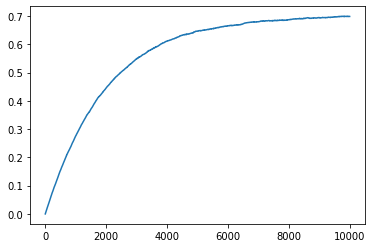

In [29]:
a = torch.rand((10000, 5))
print (a.shape)
b = (a < 0.7).float()
print (b.mean())

est = 0
N = 100
y = 0.0005
import matplotlib.pyplot as plt
d = [est]
for i in b:
#     print (est)
    est += y*(i.mean().item()-est)
#     est += i
    d.append(est)
print (est)
plt.plot(d)
plt.show()
    

In [54]:
def entropy(means):
    zeromask = (means == 0).float()
    onesmask = (means == 1).float()
    safemean = 1e-8*zeromask - 1e-8*onesmask + means
    
    return - safemean*torch.log2(safemean) - (1-safemean)*torch.log2(1-safemean)

def tent(means):
    less = (means < 0.5).float()
    more = (means >= 0.5).float()
    return 2*(means*less + (1-means)*more)

class AWSDM(nn.Module):
    def __init__(self, addressDim, messageDim=None, locations=100, gamma=0.005,
                 init_radius=1, target_p=0.1, r_lr=0.001,
                 dtype=torch.int16, readtype=torch.uint8, weightFunc=entropy):
        super().__init__()
        if (messageDim is None):
            messageDim = addressDim
        
        self.addressDim = addressDim
        self.messageDim = messageDim
        self.N = locations
        self.radius = initradius
        self.target_p = target_p
        self.r_lr = r_lr
        self.dtype = dtype
        self.readtype = readtype
        
        self.weightFunc = weightFunc 
        
        self.gamma = gamma
        
        self.register_buffer('locations', torch.randint(0,2, (1, locations, addressDim), dtype=torch.int8))
        self.register_buffer('counter', torch.zeros((1, locations, messageDim), dtype=dtype))
        self.register_buffer('means', 0.5*torch.ones(1, 1, addressDim, dtype=torch.float))
        
    def _checkInput(self, input, dim, name):
        # Input shape checking (and fixing) function
        if (len(input.shape) == 1):
            input = input.unsqueeze(0).unsqueeze(0)
        elif (len(input.shape) == 2):
            input = input.unsqueeze(1)
        elif (len(input.shape) == 3):
            pass
        else:
            raise ValueError("{} has bad shape, got {}".format(name, input.shape))
            
        if (input.shape[2] != dim):
            raise ValueError("{} has wrong dimension, got {} expected {}".format(name, input.shape[1], dim))
        
        return input
    
    def _getActive(self, address):
        with torch.no_grad():
            address = address.char()
            address = self._checkInput(address, self.addressDim, "Address")
            # Calculate Hamming distance 
            # Note the sum is int16  goes to 32,767 should avoid overflow
            # TODO try using .fmod_() (inplace modulo)
            hamming = ((self.locations + address).fmod_(2)).float()
            hamming *= self.weightFunc(self.means)
            hamming = hamming.sum(-1, keepdim=True, dtype=torch.int16)
            # Return array
            return (hamming <= self.radius).char()
        
    def _updateMeans(self, address):
        address = self._checkInput(address, self.addressDim, "Address")
        mean = address.float().mean(0, keepdim=True,)
        self.means += self.gamma*(mean-self.means)
    
    def write(self, address, message):
        with torch.no_grad():
            message = message.char()
            message = self._checkInput(message, self.messageDim, "Message")
            message = 2 * message - 1
            
            self._updateMeans(address)
            active = self._getActive(address)
            self.counter += (active*message.expand(-1, self.N, -1)).sum(0, keepdim=True, dtype=self.dtype)
            
            # Update p
            if (active.float().mean(-1) < self.target_p):
                self.radius += self.r_lr
            else:
                self.radius -= self.r_lr
            
    def read(self, address):
        with torch.no_grad():
            active = self._getActive(address).to(self.dtype)
            result = (active*self.counter).sum(1, dtype=self.dtype)
            return (result > 0).to(self.readtype)

In [42]:
# multi write
devices = ['cuda:0', 'cpu']

AD = 1000
MD = 100
L = 10000

S = 100

for device in devices:
    at = 0
    aa = 0
    for i in range(10):
        mem = AWSDM(AD, MD, L, readtype=torch.int8).to(device)
    #     raise ValueError("STOP 0")
        mem.radius = 451

        As = torch.randint(0,2,(S,AD),dtype=torch.int8).to(device).detach()
        Ms = torch.randint(0,2,(S,MD),dtype=torch.int8).to(device).detach()
    #     raise ValueError("STOP 1")
        start = time.time()
        mem.write(As, Ms)
    #     raise ValueError("STOP 2")
    #     print (mem.counter.abs().sum().item()//MD)
        Mrs = mem.read(As)
        end = time.time()
        acc = ((Mrs == Ms).sum().item()/(MD*S))
        
        aa += acc
        at += end-start
    
        del mem
        del As
        del Ms
        del Mrs
        del acc
    print ("Device: {:4s} Acc: {:.2f} Time: {:.5f}".format(device, aa/10, at/10))

Device: cuda:0 Acc: 0.50 Time: 0.00132
Device: cpu  Acc: 0.50 Time: 2.50959


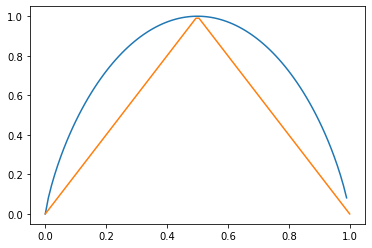

In [57]:
AD = 100
MD = 100
L = 10000

S = 1

# As = torch.randint(0,2,(S,AD),dtype=torch.int8).to(device).detach()
# mem = AWSDM(AD, MD, L, readtype=torch.int8, gamma=0.005, weightFunc=tent).to(device)
# for i in range(100):
#     mem._updateMeans(As)
# print (mem.means)
# print (mem.weightFunc(mem.means))
x = torch.linspace(0,1,100)
p = entropy(x)
plt.plot(x,p)
p = tent(x)
plt.plot(x,p)
plt.show()
